<a href="https://colab.research.google.com/github/lokeshcv/ComputerVisionDeepLearning/blob/main/pytorch_vision.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -r https://raw.githubusercontent.com/MicrosoftDocs/pytorchfundamentals/main/computer-vision-pytorch/requirements.txt

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.1/19.1 MB 35.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 776.3/776.3 MB 2.2 MB/s eta 0:00:00
  Attempting uninstall: torch
    Found existing installation: torch 2.0.1+cu118
    Uninstalling torch-2.0.1+cu118:
      Successfully uninstalled torch-2.0.1+cu118
  Attempting uninstall: torchvision
    Found existing installation: torchvision 0.15.2+cu118
    Uninstalling torchvision-0.15.2+cu118:
      Successfully uninstalled torchvision-0.15.2+cu118
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchaudio 2.0.2+cu118 requires torch==2.0.1, but you have torch 1.12.0 which is incompatible.
torchdata 0.6.1 requires torch==2.0.1, but you have torch 1.12.0 which is incompatible.
torchtext 0.15.2 requires torch==2.0.1, but you have torch 1.12.0 which is incompatible.


In [104]:
!pip install torchinfo

In [105]:
import torch
import torch.nn as nn
import torchvision
from torchinfo import summary
from torchvision.transforms import ToTensor
from matplotlib import pyplot as plt
import numpy as np

In [4]:
dir_path = '/content/data'

Load the MNIST dataset from the PyTorch Datasets

In [5]:
train_ds = torchvision.datasets.MNIST(root=dir_path, train=True,
                                      download=True,
                                      transform=ToTensor())

test_ds = torchvision.datasets.MNIST(root=dir_path, train=False,
                                      download=True,
                                      transform=ToTensor())

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting /content/data/MNIST/raw/train-images-idx3-ubyte.gz to /content/data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting /content/data/MNIST/raw/train-labels-idx1-ubyte.gz to /content/data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting /content/data/MNIST/raw/t10k-images-idx3-ubyte.gz to /content/data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting /content/data/MNIST/raw/t10k-labels-idx1-ubyte.gz to /content/data/MNIST/raw



In [9]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

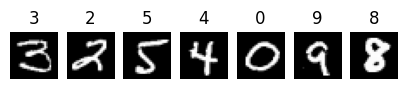

In [30]:
idx = torch.randint(0,len(train_ds), size=(7,), device=device)
figure = plt.figure(figsize=(5,3))
for i, ids in enumerate(idx):
  plt_idx = int(f"17{i+1}")
  figure.add_subplot(plt_idx)
  plt.imshow(train_ds[ids][0][0],cmap='gray')
  plt.title(train_ds[ids][1])
  plt.axis('off')


In [32]:
print('Training samples:',len(train_ds))
print('Test samples:',len(test_ds))

print('Tensor size:',train_ds[0][0].size())
print('First 10 digits are:', [test_ds[i][1] for i in range(10)])

Training samples: 60000
Test samples: 10000
Tensor size: torch.Size([1, 28, 28])
First 10 digits are: [7, 2, 1, 0, 4, 1, 4, 9, 5, 9]


Pixel Intensity

In [34]:
print('Min intensity value: ',train_ds[0][0].min().item())
print('Max intensity value: ',train_ds[0][0].max().item())

Min intensity value:  0.0
Max intensity value:  1.0


Resuable Code for MNIST

In [76]:
# Script file to hide implementation details for PyTorch computer vision module

import torch
import torch.nn as nn
from torch.utils import data
import torchvision
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import glob
import os
import zipfile

default_device = 'cuda' if torch.cuda.is_available() else 'cpu'

def load_mnist(batch_size=64):
    data_train = torchvision.datasets.MNIST('./data',
        download=True,train=True,transform=ToTensor())
    data_test = torchvision.datasets.MNIST('./data',
        download=True,train=False,transform=ToTensor())
    train_loader = torch.utils.data.DataLoader(data_train,batch_size=batch_size)
    test_loader = torch.utils.data.DataLoader(data_test,batch_size=batch_size)

    return data_train, data_test, train_loader, test_loader

def train_epoch(net,dataloader,lr=0.01,optimizer=None,loss_fn = nn.NLLLoss()):
    optimizer = optimizer or torch.optim.Adam(net.parameters(),lr=lr)
    net.train()
    total_loss,acc,count = 0,0,0
    for features,labels in dataloader:
        optimizer.zero_grad()
        lbls = labels.to(default_device)
        out = net(features.to(default_device))
        loss = loss_fn(out,lbls) #cross_entropy(out,labels)
        loss.backward()
        optimizer.step()
        total_loss+=loss
        _,predicted = torch.max(out,1)
        acc+=(predicted==lbls).sum()
        count+=len(labels)
    return total_loss.item()/count, acc.item()/count

def validate(net, dataloader,loss_fn=nn.NLLLoss()):
    net.eval()
    count,acc,loss = 0,0,0
    with torch.no_grad():
        for features,labels in dataloader:
            lbls = labels.to(default_device)
            out = net(features.to(default_device))
            loss += loss_fn(out,lbls)
            pred = torch.max(out,1)[1]
            acc += (pred==lbls).sum()
            count += len(labels)
    return loss.item()/count, acc.item()/count

def train(net,train_loader,test_loader,optimizer=None,lr=0.01,epochs=10,loss_fn=nn.NLLLoss()):
    optimizer = optimizer or torch.optim.Adam(net.parameters(),lr=lr)
    res = { 'train_loss' : [], 'train_acc': [], 'val_loss': [], 'val_acc': []}
    for ep in range(epochs):
        tl,ta = train_epoch(net,train_loader,optimizer=optimizer,lr=lr,loss_fn=loss_fn)
        vl,va = validate(net,test_loader,loss_fn=loss_fn)
        print(f"Epoch {ep+1:2}, Train acc={ta:.3f}, Val acc={va:.3f}, Train loss={tl:.3f}, Val loss={vl:.3f}")
        res['train_loss'].append(tl)
        res['train_acc'].append(ta)
        res['val_loss'].append(vl)
        res['val_acc'].append(va)
    return res

def train_long(net,train_loader,test_loader,epochs=5,lr=0.01,optimizer=None,loss_fn = nn.NLLLoss(),print_freq=10):
    optimizer = optimizer or torch.optim.Adam(net.parameters(),lr=lr)
    for epoch in range(epochs):
        net.train()
        total_loss,acc,count = 0,0,0
        for i, (features,labels) in enumerate(train_loader):
            lbls = labels.to(default_device)
            optimizer.zero_grad()
            out = net(features.to(default_device))
            loss = loss_fn(out,lbls)
            loss.backward()
            optimizer.step()
            total_loss+=loss
            _,predicted = torch.max(out,1)
            acc+=(predicted==lbls).sum()
            count+=len(labels)
            if i%print_freq==0:
                print("Epoch {}, minibatch {}: train acc = {}, train loss = {}".format(epoch,i,acc.item()/count,total_loss.item()/count))
        vl,va = validate(net,test_loader,loss_fn)
        print("Epoch {} done, validation acc = {}, validation loss = {}".format(epoch,va,vl))


def plot_results(hist):
    plt.figure(figsize=(15,5))
    plt.subplot(121)
    plt.plot(hist['train_acc'], label='Training acc')
    plt.plot(hist['val_acc'], label='Validation acc')
    plt.legend()
    plt.subplot(122)
    plt.plot(hist['train_loss'], label='Training loss')
    plt.plot(hist['val_loss'], label='Validation loss')
    plt.legend()

def plot_convolution(data_train, t,title=''):
    with torch.no_grad():
        c = nn.Conv2d(kernel_size=(3,3),out_channels=1,in_channels=1)
        c.weight.copy_(t)
        fig, ax = plt.subplots(2,6,figsize=(8,3))
        fig.suptitle(title,fontsize=16)
        for i in range(5):
            im = data_train[i][0]
            ax[0][i].imshow(im[0])
            ax[1][i].imshow(c(im.unsqueeze(0))[0][0])
            ax[0][i].axis('off')
            ax[1][i].axis('off')
        ax[0,5].imshow(t)
        ax[0,5].axis('off')
        ax[1,5].axis('off')
        #plt.tight_layout()
        plt.show()

def display_dataset(dataset, n=10,classes=None):
    fig,ax = plt.subplots(1,n,figsize=(15,3))
    mn = min([dataset[i][0].min() for i in range(n)])
    mx = max([dataset[i][0].max() for i in range(n)])
    for i in range(n):
        ax[i].imshow(np.transpose((dataset[i][0]-mn)/(mx-mn),(1,2,0)))
        ax[i].axis('off')
        if classes:
            ax[i].set_title(classes[dataset[i][1]])


def check_image(fn):
    try:
        im = Image.open(fn)
        im.verify()
        return True
    except:
        return False

def check_image_dir(path):
    for fn in glob.glob(path):
        if not check_image(fn):
            print("Corrupt image: {}".format(fn))
            os.remove(fn)


def common_transform():
    std_normalize = torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406],
                          std=[0.229, 0.224, 0.225])
    trans = torchvision.transforms.Compose([
            torchvision.transforms.Resize(256),
            torchvision.transforms.CenterCrop(224),
            torchvision.transforms.ToTensor(),
            std_normalize])
    return trans

def load_cats_dogs_dataset():
    if not os.path.exists('data/PetImages'):
        with zipfile.ZipFile('data/kagglecatsanddogs_5340.zip', 'r') as zip_ref:
            zip_ref.extractall('data')

    check_image_dir('data/PetImages/Cat/*.jpg')
    check_image_dir('data/PetImages/Dog/*.jpg')

    dataset = torchvision.datasets.ImageFolder('data/PetImages',transform=common_transform())
    trainset, testset = torch.utils.data.random_split(dataset,[20000,len(dataset)-20000])
    trainloader = torch.utils.data.DataLoader(trainset,batch_size=32)
    testloader = torch.utils.data.DataLoader(trainset,batch_size=32)
    return dataset, trainloader, testloader

In [51]:
train_ds, test_ds, train_loader, test_loader = load_mnist()

Fully Connected Network

In [61]:
default_device, device

('cuda', 'cuda')

In [66]:
network = nn.Sequential(nn.Flatten(),
                        nn.Linear(784, 128),
                        nn.Linear(128,64),
                        nn.Linear(64, 10),
                        nn.LogSoftmax(1))

network.to(default_device)

Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=784, out_features=128, bias=True)
  (2): Linear(in_features=128, out_features=64, bias=True)
  (3): Linear(in_features=64, out_features=10, bias=True)
  (4): LogSoftmax(dim=1)
)

Train with single sample

Because we use LogSoftmax as final activation of our network, we pass network output through torch.exp to get probabilities.

In [67]:
print('Digit to be predicted: ', train_ds[0][1])
torch.exp(network(train_ds[0][0].to(default_device)))

Digit to be predicted:  5


tensor([[0.0820, 0.0911, 0.1064, 0.0894, 0.1188, 0.1065, 0.0936, 0.1117, 0.0915,
         0.1089]], device='cuda:0', grad_fn=<ExpBackward0>)

The training process steps are as follows:


1.   We take a minibatch from the input dataset, which consists of input data (features) and expected result (label).
2.   We calculate the predicted result for this minibatch.
3.   The difference between this result and expected result is calculated using a special function called the loss function. Loss function shows how different the output of the network is from the expected output. The goal of our training is to minimize the loss.
4.   We calculate the gradients of this loss function with respect to model weights (parameters), which are then used to adjust the weights to optimize the performance of the network. The amount of adjustment is controlled by a parameter called learning rate, and the details of optimization algorithm are defined in the optimizer object.
5.    We repeat those steps until the whole dataset is processed. One complete pass through the dataset is called an epoch.


Train

In [70]:
lr =1e-3
SGD_opt = torch.optim.SGD(params=network.parameters(),lr=lr)
loss_function = nn.CrossEntropyLoss()
train_epoch(network, train_loader,
            lr=lr,
            optimizer=SGD_opt,
            loss_fn= loss_function)

(0.027975557454427084, 0.6926166666666667)

In [71]:
validate(network, test_loader)

(0.02518406982421875, 0.7104)

In [77]:
hist = train(network,train_loader,test_loader,epochs=10,
             lr=lr, optimizer=SGD_opt, loss_fn= loss_function)

Epoch  1, Train acc=0.884, Val acc=0.891, Train loss=0.006, Val loss=0.006
Epoch  2, Train acc=0.886, Val acc=0.892, Train loss=0.006, Val loss=0.006
Epoch  3, Train acc=0.888, Val acc=0.893, Train loss=0.006, Val loss=0.006
Epoch  4, Train acc=0.890, Val acc=0.895, Train loss=0.006, Val loss=0.006
Epoch  5, Train acc=0.891, Val acc=0.895, Train loss=0.006, Val loss=0.006
Epoch  6, Train acc=0.893, Val acc=0.897, Train loss=0.006, Val loss=0.006
Epoch  7, Train acc=0.894, Val acc=0.898, Train loss=0.006, Val loss=0.006
Epoch  8, Train acc=0.895, Val acc=0.899, Train loss=0.006, Val loss=0.006
Epoch  9, Train acc=0.896, Val acc=0.900, Train loss=0.006, Val loss=0.005
Epoch 10, Train acc=0.898, Val acc=0.901, Train loss=0.006, Val loss=0.005


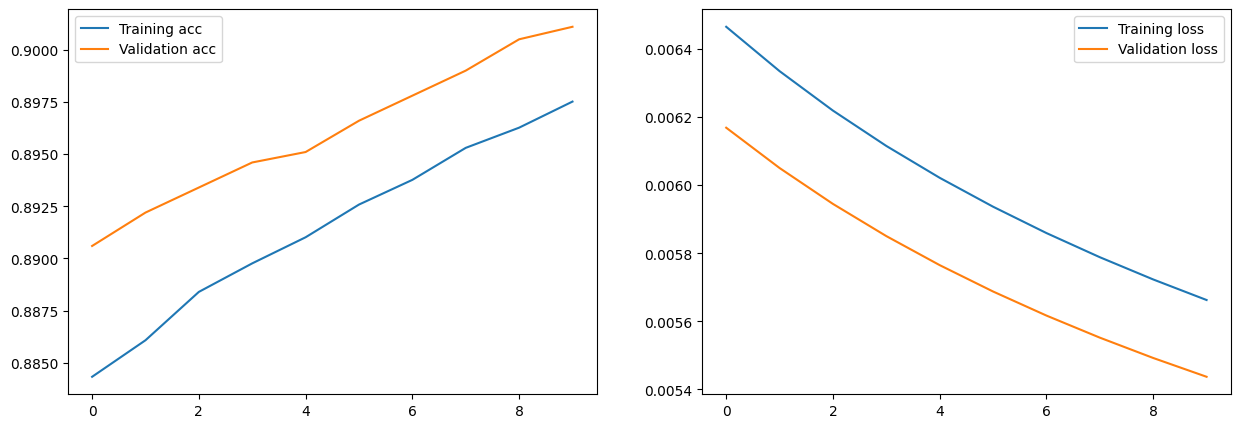

In [78]:
plot_results(hist)

Visualizing network weights

In the code below, we will first get the matrix W into weight_tensor variable. It can be obtained by calling the network.parameters() method (which returns both W and b), and then calling next to get the first of two parameters. Then we will go over each dimension, reshape it to 28×28 size, and plot. You can see that 10 weight tensor dimensions somewhat resemble the average shape of the digits they classify:

torch.Size([128, 784])


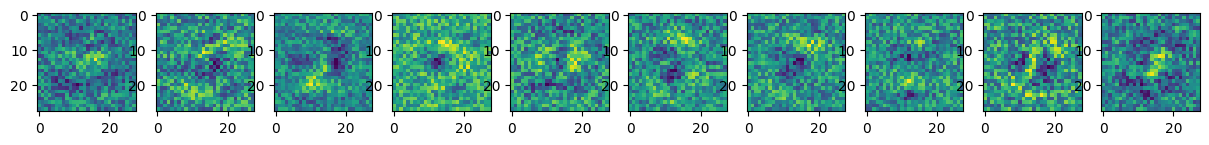

In [101]:
# weight_tensor = next(network.parameters())

weight_tensor = list(network.parameters())[0]
print(weight_tensor.shape)
fig,ax = plt.subplots(1,10,figsize=(15,4))
for i,x in enumerate(weight_tensor):
  if i <= 9:
    ax[i].imshow(x.view(28,28).cpu().data.numpy())
  else:
    break

 It is important to introduce those non-linear activation functions, because they are one of the reasons neural networks achieve high expressive power. Indeed, it can be demonstrated mathematically that if a network consisted just of a series of linear layers, it would essentially be equivalent to one linear layer. Thus inserting non-linear functions in between layers is important!

ReLU is a simplest activation function, which is defined as follows:

In [106]:
network = nn.Sequential(nn.Flatten(),
                        nn.Linear(784, 128),
                        nn.ReLU(),
                        nn.Linear(128,64),
                        nn.ReLU(),
                        nn.Linear(64, 10),
                        nn.LogSoftmax(1))

network.to(default_device)
summary(network,input_size=(1,28,28))

Layer (type:depth-idx)                   Output Shape              Param #
Sequential                               [1, 10]                   --
├─Flatten: 1-1                           [1, 784]                  --
├─Linear: 1-2                            [1, 128]                  100,480
├─ReLU: 1-3                              [1, 128]                  --
├─Linear: 1-4                            [1, 64]                   8,256
├─ReLU: 1-5                              [1, 64]                   --
├─Linear: 1-6                            [1, 10]                   650
├─LogSoftmax: 1-7                        [1, 10]                   --
Total params: 109,386
Trainable params: 109,386
Non-trainable params: 0
Total mult-adds (M): 0.11
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.44
Estimated Total Size (MB): 0.44

In [125]:
from torch.nn.functional import relu, log_softmax

class Mnist_Net(nn.Module):
    def __init__(self):
        super(Mnist_Net, self).__init__()
        self.flatten = nn.Flatten()
        self.hidden_1 = nn.Linear(784, 128)
        self.relu1 = nn.ReLU()
        self.relu2 = nn.ReLU()
        self.hidden_2 = nn.Linear(128,64)
        self.out = nn.Linear(64, 10)

    def forward(self, x):
        x = self.flatten(x)
        x = self.hidden_1(x)
        x = self.relu1(x)
        x = self.hidden_2(x)
        x = self.relu2(x)
        x = self.out(x)
        x = log_softmax(x,dim=1)
        return x

net = Mnist_Net().to(default_device)

summary(net,input_size=(1,28,28),device=default_device)

Layer (type:depth-idx)                   Output Shape              Param #
Mnist_Net                                [1, 10]                   --
├─Flatten: 1-1                           [1, 784]                  --
├─Linear: 1-2                            [1, 128]                  100,480
├─ReLU: 1-3                              [1, 128]                  --
├─Linear: 1-4                            [1, 64]                   8,256
├─ReLU: 1-5                              [1, 64]                   --
├─Linear: 1-6                            [1, 10]                   650
Total params: 109,386
Trainable params: 109,386
Non-trainable params: 0
Total mult-adds (M): 0.11
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.44
Estimated Total Size (MB): 0.44

Epoch  1, Train acc=0.921, Val acc=0.953, Train loss=0.004, Val loss=0.003
Epoch  2, Train acc=0.954, Val acc=0.939, Train loss=0.002, Val loss=0.003
Epoch  3, Train acc=0.964, Val acc=0.954, Train loss=0.002, Val loss=0.003
Epoch  4, Train acc=0.966, Val acc=0.959, Train loss=0.002, Val loss=0.003
Epoch  5, Train acc=0.968, Val acc=0.959, Train loss=0.002, Val loss=0.003


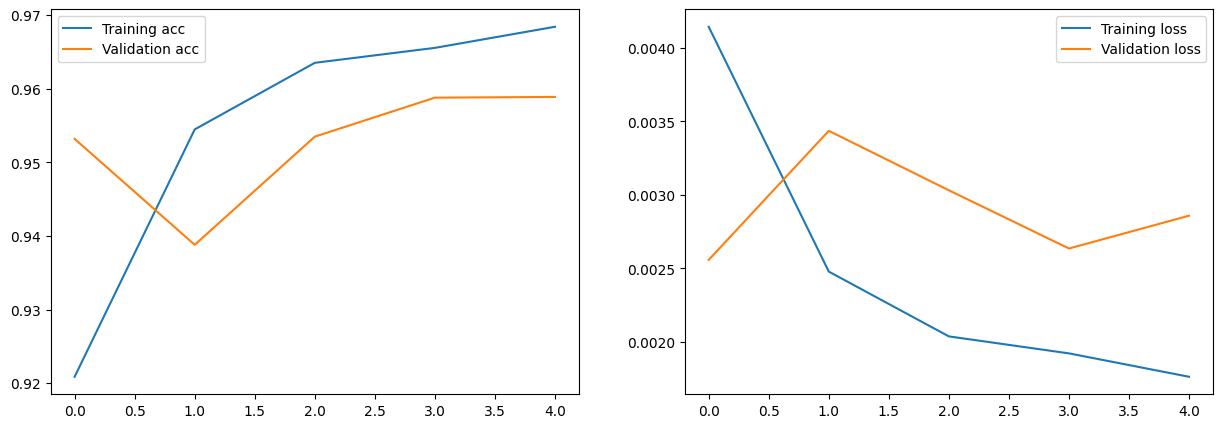

In [126]:
hist = train(net, train_loader,test_loader, epochs=5)

plot_results(hist)